[*********************100%***********************]  5 of 5 completed
/var/folders/z6/6r_68ptx2h500r67ddks3tjr0000gn/T/ipykernel_83133/2870307542.py:18: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data = data.stack(level=1).reset_index()
/var/folders/z6/6r_68ptx2h500r67ddks3tjr0000gn/T/ipykernel_83133/2870307542.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sharpe_ratios = data.groupby("Ticker").apply(ratio_sharpe)*100


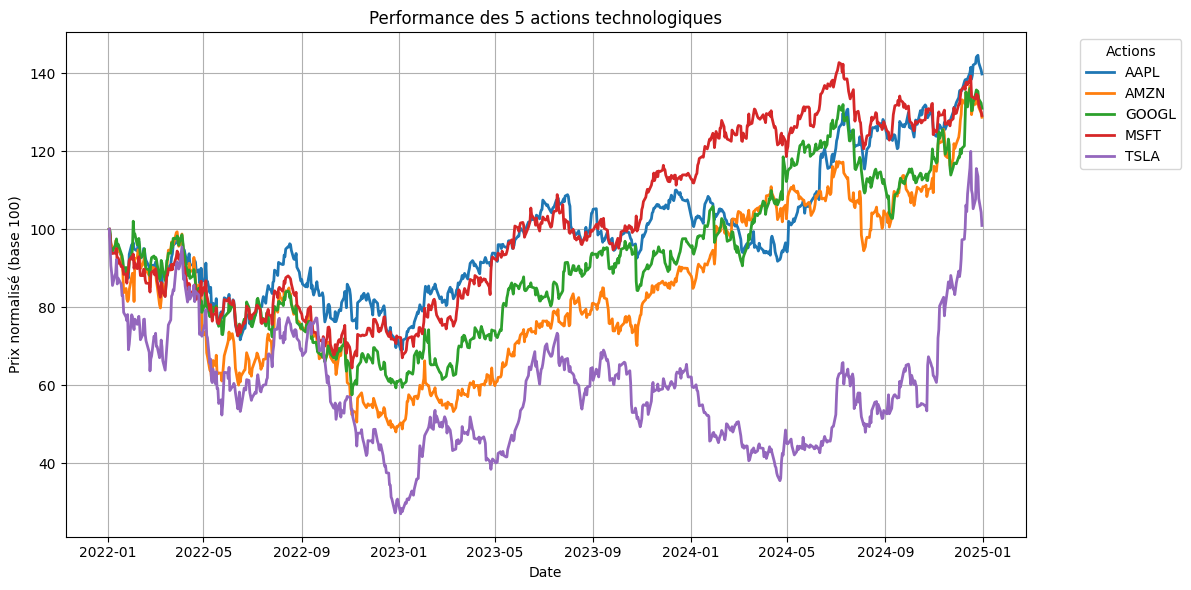

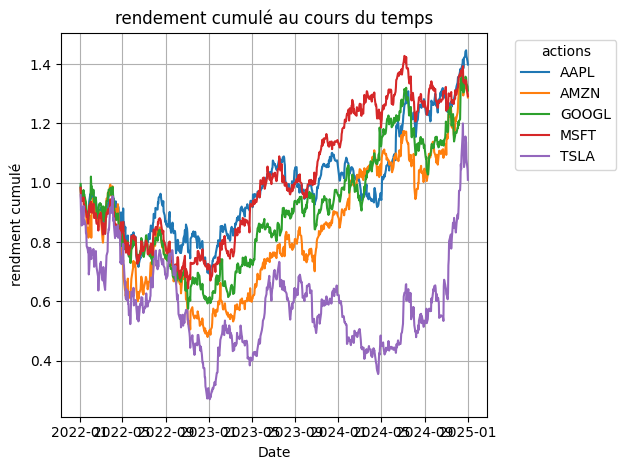

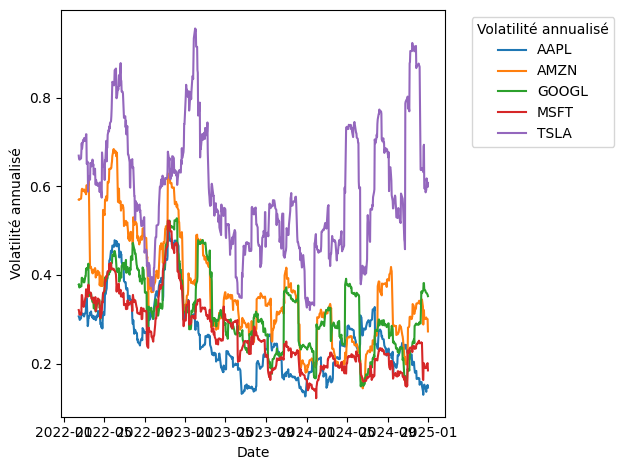

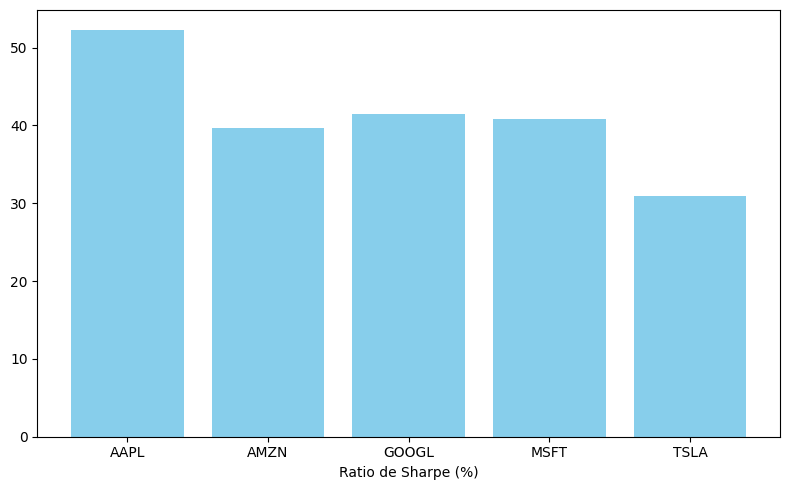

[0.8132037772915673, 0.00889817611416921, 0.6212108985875815, 0.6520175626043118, 0.8364093658534386]
       Pondération  Capital par actions
AAPL      0.277379         27737.924857
MSFT      0.003035           303.511798
GOOGL     0.211892         21189.155420
AMZN      0.222400         22239.953455
TSLA      0.285295         28529.454470
le rendemnt du portefeuille en pourcentage est 0.8277761503510919
=== Pondérations optimales ===
AAPL  : 71.40%
AMZN  : 13.03%
GOOGL : 14.24%
MSFT  :  0.00%
TSLA  :  1.32%

Rendement annuel attendu : 15.11%
Volatilité annuelle       : 26.44%
Ratio de Sharpe           :   0.50


In [23]:
import yfinance as yf 
import pandas as pd
import holidays
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import minimize 

# List of stock tickers
stock = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]

# Download historical stock data
data = yf.download(stock, start="2022-01-01", end="2025-01-01")

# Keep only Close, Open, and Volume
data = data[["Close", "Open", "Volume"]]

# Stack tickers into rows and reset index
data = data.stack(level=1).reset_index()
data.columns = ["Date", "Ticker", "Close", "Open", "Volume"]
data["Date"] = pd.to_datetime(data["Date"])

# Get US holidays from 2022 to 2024 (range is exclusive of end)
ferie = holidays.US(years=range(2022, 2025))
dataf = pd.DataFrame(list(ferie.items()), columns=["Date", "jour ferie"])
dataf.set_index("Date", inplace=True)

dataf.index = pd.to_datetime(dataf.index)

# Merge holiday data with stock data
data = pd.merge(data, dataf, how="left", on="Date")


data["jour ferie"] = data["jour ferie"].isna()

data = data[data["jour ferie"] == True]
data["Rendement"] = data.groupby("Ticker")["Close"].pct_change()

data["redemnt logarithmique"] = np.log(data["Close"]/data.groupby("Ticker")["Close"].shift(1))



data["rendment cumulé"] = data.groupby("Ticker")["Rendement"].transform(lambda x: (1+x).cumprod())



data["Volatilité annualisé"] = data.groupby("Ticker")["Rendement"].transform(lambda x: x.rolling(window = 30).std()*np.sqrt(252))

def ratio_sharpe(group):
    mean_daily_return = group["Rendement"].mean()
    rendement_anualisé = (1 + mean_daily_return)**252 -1 
    daily_volatility = group["Rendement"].std()
    annualised_volatility = daily_volatility*np.sqrt(252)
    sharpe = (rendement_anualisé - 0.02)/annualised_volatility
    return sharpe

sharpe_ratios = data.groupby("Ticker").apply(ratio_sharpe)*100

sharpe_ratios.head()

data["Close_norm"] = data.groupby("Ticker")["Close"].transform(lambda x : (x/x.iloc[0])*100)


plt.figure(figsize=(12, 6))

# Tracer chaque ligne avec son label
for ticker, group in data.groupby('Ticker'):
    plt.plot(group['Date'], 
             group['Close_norm'], 
             label=ticker,  # Ce paramètre est crucial
             linewidth=2)

# Ajouter la légende
plt.legend(title='Actions',
           bbox_to_anchor=(1.05, 1),  # Place la légende à droite
           loc='upper left')

# Personnalisation
plt.xlabel('Date')
plt.ylabel('Prix normalisé (base 100)') 
plt.title('Performance des 5 actions technologiques')
plt.grid(True)
plt.tight_layout()  # Ajuste les marges
plt.show()

for ticker, group in data.groupby("Ticker"):
    plt.plot(group["Date"], group["rendment cumulé"], label=ticker)

plt.legend(title = "actions", bbox_to_anchor = (1.05,1), loc ="upper left")

plt.xlabel("Date")
plt.ylabel("rendment cumulé")
plt.title("rendement cumulé au cours du temps")
plt.grid(True)
plt.tight_layout()
plt.show()

for ticker, group in data.groupby("Ticker"):
    plt.plot(group["Date"], group["Volatilité annualisé"], label=ticker)
plt.legend(title="Volatilité annualisé", bbox_to_anchor =(1.05,1), loc="upper left")
plt.xlabel("Date")
plt.ylabel("Volatilité annualisé")
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 5))
plt.bar(sharpe_ratios.index, sharpe_ratios.values, color="skyblue")
plt.xlabel("Ratio de Sharpe (%)")
plt.tight_layout()
plt.show()



ca_init = 100000

Pond = []
r = 0
for i in range(len(stock)): 
    r = np.random.rand()
    Pond.append((r))
print(Pond)
somme_weight = np.sum(Pond)
Pond = Pond/somme_weight

portefeuille = pd.DataFrame({"Pondération": Pond}, index=stock)



portefeuille["Capital par actions"] = portefeuille["Pondération"]*ca_init

print(portefeuille)

def Rendport(group1, group2): 
    somme = 0
    for ticker, group in group1.groupby("Ticker"): 
        somme = somme + group["rendment cumulé"].mean()*group2.loc[ticker, "Pondération"]
    return somme

print(f'le rendemnt du portefeuille en pourcentage est {Rendport(data, portefeuille)}')




# ------------------------------------------------------------------
# 1. Matrice des rendements quotidiens (déjà dans data["Rendement"])
# ------------------------------------------------------------------
returns = (data
           .pivot(index="Date", columns="Ticker", values="Rendement")
           .dropna())


mu  = returns.mean().values          # moyenne quotidienne par titre
cov = returns.cov().values           # matrice de covariance

# ------------------------------------------------------------------
# 2. Optimisation du Sharpe
# ------------------------------------------------------------------
from scipy.optimize import minimize
rf = 0.02                            # taux sans risque annuel

def neg_sharpe(w, mu, cov, rf):
    # rendement et volatilité annualisés
    port_ret = np.dot(w, mu) * 252
    port_vol = np.sqrt(w @ cov @ w *252)
    return -(port_ret - rf) / port_vol   # on MINIMISE le négatif

n = len(mu)
x0 = np.full(n, 1/n)                 # départ : pondérations égales
bounds      = [(0, 1)] * n           # pas de vente à découvert
constraints = {'type': 'eq', 'fun': lambda w: w.sum() - 1}

opt = minimize(neg_sharpe, x0,
               args=(mu, cov, rf),
               bounds=bounds,
               constraints=constraints)

w_opt = opt.x

# ------------------------------------------------------------------
# 3. Résultats
# ------------------------------------------------------------------
port_ret = np.dot(w_opt, mu) * 252
port_vol = np.sqrt(w_opt @ cov @ w_opt * 252)
sharpe   = (port_ret - rf) / port_vol

print("=== Pondérations optimales ===")
for t, w in zip(returns.columns, w_opt):
    print(f"{t:5s} : {w:6.2%}")

print(f"\nRendement annuel attendu : {port_ret:6.2%}")
print(f"Volatilité annuelle       : {port_vol:6.2%}")
print(f"Ratio de Sharpe           : {sharpe:6.2f}")

